In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra
from pyiga import assemble
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists
import itertools
from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)
import numba as nb    
from numba import njit


Populating the interactive namespace from numpy and matplotlib


In [2]:
class IetiDP:
    def __init__(self, MP, dir_data, neu_data=None, elim=True):
        self.space = MP
        self.elim=elim
        
        self.dir_idx=dict()
        self.dir_vals=dict()
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        for key in dir_data:
            for p,b in self.space.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(self.dir_idx[p], return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
        
        if self.elim:
            dofs=dict()
            Basis=MP.Basis.tocsc()
            constr=[]
            for p in range(MP.numpatches):
                idx_per_col = [Basis.indices[Basis.indptr[c]:Basis.indptr[c+1]] for c in range(Basis.shape[1])]
                dofs[p] = np.where([np.any((i<MP.N_ofs[p+1]) & (i>=MP.N_ofs[p])) for i in idx_per_col])[0]
                #print(dofs)
            N = [len(dofs_) for dofs_ in dofs.values()]
            N_ofs = np.cumsum([0]+N)

            self.Basisk=[Basis[MP.N_ofs[p]:MP.N_ofs[p+1],:][:,dofs[p]] for p in range(MP.numpatches)]

            J1=[]
            J2=[]
            for (p1,b1,_),(p2,b2,_),_ in MP.intfs:
                #print(np.intersect1d(dofs[p1],dofs[p2]))
                J1.append([np.where(dofs[p1]==g)[0][0]+N_ofs[p1] for g in np.intersect1d(dofs[p1],dofs[p2])])
                J2.append([np.where(dofs[p2]==g)[0][0]+N_ofs[p2] for g in np.intersect1d(dofs[p1],dofs[p2])])

            J1=np.concatenate(J1)
            J2=np.concatenate(J2)
            data=np.r_[np.ones(len(J1)),-np.ones(len(J2))]
            I=np.r_[np.arange(len(J1)),np.arange(len(J2))]
            J = np.r_[J1,J2]
            self.B = scipy.sparse.coo_matrix((data,(I,J)),(len(J1),sum(N))).tocsr()
        else:
            self.Basisk = [scipy.sparse.identity(MP.N[p]) for p in range(MP.numpatches)]
            self.B = MP.Constr
            
        self.N = [Ba.shape[1] for Ba in self.Basisk]
        self.N_ofs = np.cumsum([0]+self.N)
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]
        self.Basis=scipy.sparse.block_diag(self.Basisk)
        self.P2Gk =[]
        
        for p in range(self.space.numpatches):
            X = self.Basisk[p].tocoo()
            idx = np.where(np.isclose(X.data,1))
            X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
            D = (X.T@self.Basisk[p]).sum(axis=1).A.ravel()
            #assert all(abs(D)>1e-12), 'D has zeros.'
            #S = scipy.sparse.spdiags(1/D,[0],len(D),len(D))
            self.P2Gk.append(X.T)
            I = np.zeros(self.Basisk[p].shape[0])
            if p in self.dir_idx:
                I[self.dir_idx[p]] = 1
                self.dir_idx[p] = np.where(np.isclose(self.P2Gk[p]@I,1))[0]
        
        self.P2G = scipy.sparse.block_diag(self.P2Gk)
        self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        self.free_dofs = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx)
        self.free_dofs_pp = [np.arange(self.N[p]) if p not in self.dir_idx else np.setdiff1d(np.arange(self.N[p]),self.dir_idx[p]) for p in range(self.space.numpatches)]
        
        #self.B = self.B @ scipy.sparse.block_diag(self.Basisk)
        
        nnz_per_col = self.B.getnnz(axis=0)
        self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.skeleton = np.union1d(self.intfs, self.global_dir_idx)
        
        self.Rbb = []
        self.Rii = []
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask = np.zeros(self.N[p], dtype=bool)
            nnz_per_col = self.Bk[p].getnnz(axis=0)
            if p in self.dir_idx:
                intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.dir_idx[p])
            else:
                intfs = np.where(nnz_per_col > 0)[0]
            mask[intfs]=True
            if p in self.dir_idx:
                mask[self.dir_idx[p]]=False
            self.Rbb.append(Id[mask].tocsc())
            mask = np.ones(self.N[p], dtype=bool)
            mask[intfs]=False
            if p in self.dir_idx:
                mask[self.dir_idx[p]]=False
            self.Rii.append(Id[mask].tocsc())
            
#         Id = scipy.sparse.eye(self.Basis.shape[0], format='csr')
#         mask = np.zeros(self.Basis.shape[0], dtype=bool)
#         mask[self.intfs] = True
#         mask[self.global_dir_idx]=False
#         self.Rbb = Id[mask].tocsc()
#         mask = np.ones(self.Basis.shape[0], dtype=bool)
#         mask[self.skeleton] = False
#         self.Rii = Id[mask].tocsc()
        
        #self.B = self.B[:,self.free_dofs]

        #self.dir_ofs = np.cumsum(np.array([len(np.unique(idx[p])) for p in range(MP.numpatches)]))
        
    def assemble(self, f):
        Ak = [Ba.T @ assemble.assemble('(inner(grad(u),grad(v)))* dx', kvs, bfuns=[('u',1), ('v',1)], geo=geo)@Ba for Ba, ((kvs, geo),_) in zip(self.Basisk, self.space.mesh.patches)]
        A = scipy.sparse.block_diag(Ak, format='csr')
        rhsk = [Ba.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f).ravel() for Ba, ((kvs, geo),_) in zip(self.Basisk,self.space.mesh.patches)]

        # self.Abb = self.Rbb.dot(A).dot(self.Rbb.T)
        # self.Aii = self.Rii.dot(A).dot(self.Rii.T)
        # self.Abi = self.Rbb.dot(A).dot(self.Rii.T)
        # self.Aib = self.Abi.T
        
        BCRestr = {p:assemble.RestrictedLinearSystem(Ak[p], rhsk[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        self.rhsk = [rhsk[p] if p not in self.dir_idx else BCRestr[p].b for p in range(self.space.numpatches)]
        self.Ak = [Ak[p] if p not in self.dir_idx else BCRestr[p].A for p in range(self.space.numpatches)]
        self.A = scipy.sparse.block_diag(self.Ak)
        # self.A = BCRestr.A
        # self.rhs = BCRestr.b
        
    def construct_primal_constraints(self):
        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        self.eliminate_constraints = np.array([], dtype=int)
        Nodes=self.space.get_nodes()
        self.Prim = {}
        
        if self.elim:
            total_dofs=set()
            i=0
            for key in Nodes:
                if isinstance(key,tuple):
                    dofs = self.Basis.tocsr()[Nodes[key][1],:].indices
                    #print(dofs)
                    for dof in dofs:
                        if dof not in total_dofs:
                            total_dofs.add(dof)
                            self.Prim[i] = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                            i+=1
                else:
                    self.Prim[i] = self.Basis.tocsr()[Nodes[key][0],:].indices
                    i+=1
            loc_c_prim = np.concatenate([self.Prim[key] for key in self.Prim])
            #print(loc_c_prim)
            loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i]) for i in self.Prim])
            self.Prim_pp = {p : (loc_c_prim[(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1])],loc_c_prim_idx[(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1])]) for p in range(self.space.numpatches)}
        else:
            self.Prim = {i: val for i,val in enumerate(self.space.get_nodes().values())}
            loc_c_prim = np.concatenate([Nodes[key][0] for key in Nodes])
            loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i][0]) for i in self.Prim])
            self.cpp = {p : (loc_c_prim[(loc_c_prim >= self.space.N_ofs[p]) & (loc_c_prim < self.space.N_ofs[p+1])],loc_c_prim_idx[(loc_c_prim >= self.space.N_ofs[p]) & (loc_c_prim < self.space.N_ofs[p+1])]) for p in range(self.space.numpatches)}
            self.tpp = {p : {key:val for key,val in self.Prim.items() if len(val)>1 and all((val[1] >= self.space.N_ofs[p]) & (val[1] < self.space.N_ofs[p+1]))} for p in range(self.space.numpatches)}
        
        for p in range(len(self.space.mesh.patches)):
            if p in self.dir_idx:
                to_eliminate = self.dir_idx[p]
            else:
                to_eliminate = np.array([])
            free = np.setdiff1d(np.arange(self.N[p]),to_eliminate)
            #c_primal_free = self.cpp[p][0] - self.space.N_ofs[p]
                
            if self.elim:
                c_primal_free = self.Prim_pp[p][0] - self.N_ofs[p]
                #print(c_primal_free)
                data = np.ones(len(c_primal_free))
                rows = np.arange(len(c_primal_free))
                cols = c_primal_free
                ck = coo_matrix((data, (rows, cols)),(len(c_primal_free),self.N[p])).tocsc()
                ck = ck[:,free]
                self.Ck.append(ck.tocsr())
                m, n = ck.shape[0], len(self.Prim)
                jj = self.Prim_pp[p][1]
                self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
                
                nnz_per_row = self.B[:,self.Prim_pp[p][0]].getnnz(axis=1)
                result = np.where(nnz_per_row > 0)[0]

                self.eliminate_constraints = np.union1d(result, self.eliminate_constraints)
            else:
                c_primal_free = self.cpp[p][0] - self.space.N_ofs[p]

                # if self.elim:
                #     I = np.zeros(self.Basisk[p].shape[0])
                #     I[c_primal_free] = 1
                #     c_primal_free = np.where(np.isclose(self.P2Gk[p]@I,1))[0]

                nnz_per_row = self.space.Constr[:,self.cpp[p][0]].getnnz(axis=1)
                result = np.where(nnz_per_row > 0)[0]

                self.eliminate_constraints = np.union1d(result, self.eliminate_constraints)

                data = np.ones(len(c_primal_free))
                rows = np.arange(len(c_primal_free))
                cols = c_primal_free
                ck = coo_matrix((data, (rows, cols)),(len(c_primal_free),self.space.N[p])).tocsc()

                V = []
                for t in self.tpp[p]:
                    constr = (self.space.Constr.tocsc()[:,self.tpp[p][t][0][0]]==1).indices
                    self.eliminate_constraints = np.union1d(constr, self.eliminate_constraints)
                    X = self.space.Constr[constr,:][:,self.space.N_ofs[p]:self.space.N_ofs[p+1]].tocsr()
                    V.append(X[X.getnnz(axis=1)>0,:])
                ck = (scipy.sparse.vstack([ck]+V)@self.Basisk[p]).tocsc()

                ck = ck[:,free]
                self.Ck.append(ck.tocsr())
                m, n = ck.shape[0], len(Nodes)
                jj = np.concatenate([self.cpp[p][1],np.array(list(self.tpp[p].keys()), dtype=int)])
                #print(m, jj)
                self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
                #print(ck.A)
            
        #self.eliminate_constraints = np.unique(self.B.tocsc()[:,loc_c_prim].indices)
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_basis(self):
        PsiK=[]
        
        for p in range(len(self.space.mesh.patches)):
            a = self.Ak[p]
            c = self.Ck[p]
            AC = scipy.sparse.bmat(
            [[a, c.T],
             [c,  None   ]], format='csr')
            RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
            psi = scipy.sparse.linalg.spsolve(AC, RHS)
            psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
            if psi.ndim==1: psi=psi[:,None]
            PsiK.append(psi@self.Rk[p])

        self.Psi=np.vstack(PsiK)
        
    def compute_F(self):
        B = self.B[:,self.free_dofs]
        keep = np.where(B.getnnz(axis=1)>0)[0]
        B=B[keep,:]
        idx_p = [(self.free_dofs < self.N_ofs[p+1]) & (self.free_dofs >= self.N_ofs[p]) for p in range(self.space.numpatches)]
        Bk = [B[:,idx_p[p]] for p in range(self.space.numpatches)]
        #Bk = [b[np.where(b.getnnz(axis=1)>0)[0]] for b in Bk]
        Bk_ = [aslinearoperator(scipy.sparse.bmat([[b,np.zeros((b.shape[0],self.Ck[p].shape[0]))]], format='csr')) for p,b in enumerate(Bk)] 
        PTAP = self.Psi.T@self.A@self.Psi
        PTBT = self.Psi.T@B.T
        BP   = B@self.Psi
        
        rhs = np.concatenate(self.rhsk)
        rhsk_ = [np.concatenate([f,np.zeros(self.Ck[p].shape[0])]) for p,f in enumerate(self.rhsk)]
        
        loc_solver = [solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True) for a,c in zip(self.Ak, self.Ck)]
        F1 = aslinearoperator(BP@solvers.make_solver(PTAP, spd=True, symmetric=True).dot(BP.T)) 
        F2 = sum([b@Ak_inv.dot(b.T) for b, Ak_inv in zip(Bk_,loc_solver)])

        b1 = BP@solvers.make_solver(PTAP, spd=True, symmetric=True).dot(self.Psi.T@rhs)
        b2 = sum([b@Ak_inv@f for b, Ak_inv,f in zip(Bk_, loc_solver, rhsk_)])
        
        return F1+F2, b1+b2
    
    def MsD(self, pseudo=False):
        B = self.B[:,self.free_dofs]
        keep = np.where(B.getnnz(axis=1)>0)[0]
        B = B[keep]
        Bk = [self.Bk[p][keep,:][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)] 
        Rb = [self.Rbb[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]
        Ri = [self.Rii[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]
        self.B_gamma = scipy.sparse.hstack([Bk[p]@Rb[p].T for p in range(self.space.numpatches)])

        Abb = [aslinearoperator(Rb[p]@self.Ak[p]@Rb[p].T) for p in range(self.space.numpatches)]
        Aii = [Ri[p]@self.Ak[p]@Ri[p].T for p in range(self.space.numpatches)]
        Abi = [aslinearoperator(Rb[p]@self.Ak[p]@Ri[p].T) for p in range(self.space.numpatches)]
        
        self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(Abb,Abi,Aii)]
        ofs = np.cumsum([0]+[s.shape[0] for s in self.S])
        #print(self.S)
        
        if self.elim:
            D = self.B_gamma.getnnz(axis=0)
            D = 1/(1+D)
            self.D = scipy.sparse.diags(D, format='csr')
        else:
            if pseudo:
                t = time.time()
                D = np.linalg.pinv(self.B_gamma.A)
                D[abs(D)<1e-16]=0.0
                print("computing the pseudoinverse and pruning took " + str(time.time()-t) + " seconds.")
                D=scipy.sparse.csr_matrix(D)
                self.D=D@D.T
            else:
                D = self.B_gamma.getnnz(axis=0)
                D = 1/(1+D)
                self.D = scipy.sparse.diags(D, format='csr')
        self.BgD = self.B_gamma@self.D
        # for p in range(self.space.numpatches):
        #     print(self.BgD[:,ofs[p]:ofs[p+1]].shape, self.S[p].shape, self.BgD[:,ofs[p]:ofs[p+1]].T.shape)
        return sum([aslinearoperator(self.BgD[:,ofs[p]:ofs[p+1]])@self.S[p].dot(aslinearoperator(self.BgD[:,ofs[p]:ofs[p+1]].T)) for p in range(self.space.numpatches)])

In [3]:
def checkerboard(deg,N,k):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((2,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    geometry.unit_square().translate((2,1)),
    geometry.unit_square().translate((0,2)),
    geometry.unit_square().translate((1,2)),
    geometry.unit_square().translate((2,2)),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==1})
    return M

In [4]:
def Lshape(deg,N):
    patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.unit_square())]
    M = topology.PatchMesh(patches)

    for i in range(10):
        M.h_refine({0:None})
    return M

setting up constraints took 0.018702030181884766 seconds.
Basis setup took 0.00806736946105957 seconds
Initializing took 0.023406505584716797 seconds.
Assembling took 0.0875844955444336 seconds.
Constructing primal system took 0.026769638061523438 seconds.
Constructing Schur complement operator took 0.015816450119018555 seconds.
computing the pseudoinverse and pruning took 0.0004646778106689453 seconds.
Constructing preconditioner took 0.021523237228393555 seconds.
pcg with preconditioned condition number 2.5880723820274008 stopped after 2 iterations with relres 1.2403337362420715e-07
6.0154204803476485 0.17701571114647469
#####################################################


/home/wolfman/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


setting up constraints took 0.021404504776000977 seconds.
Basis setup took 0.008534431457519531 seconds
Initializing took 0.024007081985473633 seconds.
Assembling took 0.10376977920532227 seconds.
Constructing primal system took 0.02993917465209961 seconds.
Constructing Schur complement operator took 0.02030324935913086 seconds.
computing the pseudoinverse and pruning took 0.0013005733489990234 seconds.
Constructing preconditioner took 0.023323535919189453 seconds.
pcg with preconditioned condition number 3.3549704401314053 stopped after 3 iterations with relres 4.691787736007622e-10
9.553423726434264 0.13351541656626828
#####################################################
setting up constraints took 0.02368307113647461 seconds.
Basis setup took 0.009315013885498047 seconds
Initializing took 0.025492429733276367 seconds.
Assembling took 0.11506295204162598 seconds.
Constructing primal system took 0.04700899124145508 seconds.
Constructing Schur complement operator took 0.06511974334716

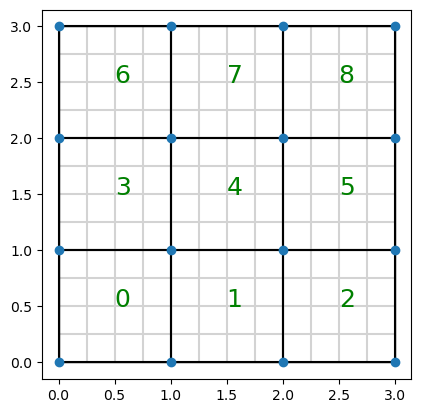

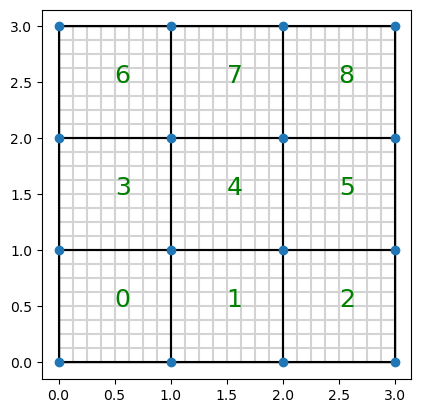

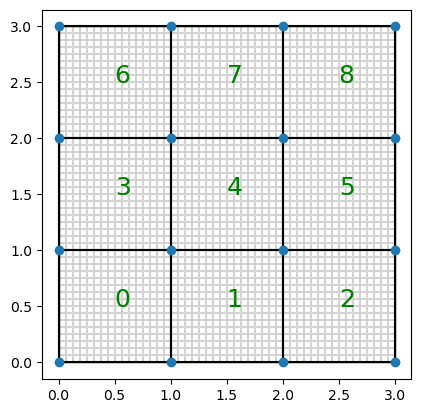

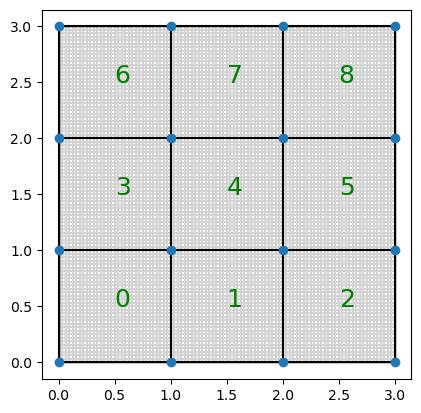

In [6]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
deg=2
elim=False

for N in (4,8,16,32):
    M = checkerboard(deg,N,0)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
    t=time.time()
    I = IetiDP(MP, dir_data = {0:g}, elim=elim)
    print("Initializing took "+str(time.time()-t)+" seconds.")
    t=time.time()
    I.assemble(f=lambda x,y: 1.)
    print("Assembling took "+str(time.time()-t)+" seconds.")
    #print(I.rhsk)
    #print(I.Ak)
    t = time.time()
    I.construct_primal_constraints()
    I.construct_primal_basis()
    print("Constructing primal system took "+str(time.time()-t)+" seconds.")
    t = time.time()
    F,b= I.compute_F()
    F_mat = F@np.eye(len(b))
    print("Constructing Schur complement operator took "+str(time.time()-t)+" seconds.")
    t=time.time()
    MsD = I.MsD(pseudo=True)
    print("Constructing preconditioner took "+str(time.time()-t)+" seconds.")
    ### Solve the system with PCG
    lam, it, cond, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=200, P=MsD, output=1, tol=1e-6)
    cond = algebra.condest(MsD@F_mat)
    print(cond,((sqrt(cond)-1)/(sqrt(cond)+1))**it)
    print("#####################################################")

setting up constraints took 0.08477044105529785 seconds.
Basis setup took 0.015252113342285156 seconds
Initializing took 0.23343491554260254 seconds.
Assembling took 0.2694666385650635 seconds.
Constructing primal system took 0.08176088333129883 seconds.
Constructing Schur complement operator took 0.04136538505554199 seconds.
Constructing preconditioner took 0.05970358848571777 seconds.
pcg with preconditioned condition number 1.426198209614544 stopped after 9 iterations with relres 9.44977342694607e-09
1.426198209614544 3.3373876044752253e-10
#####################################################
setting up constraints took 0.08109521865844727 seconds.
Basis setup took 0.01563715934753418 seconds
Initializing took 0.5854783058166504 seconds.
Assembling took 0.2898440361022949 seconds.
Constructing primal system took 0.09467029571533203 seconds.
Constructing Schur complement operator took 0.050221920013427734 seconds.
Constructing preconditioner took 0.06409072875976562 seconds.
pcg wit

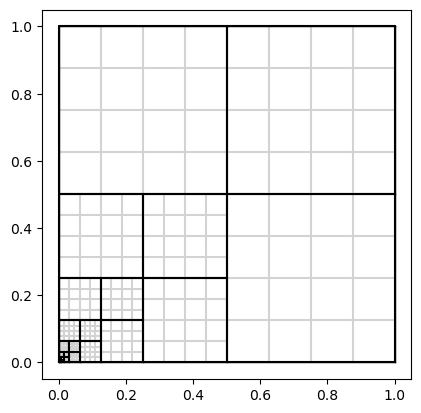

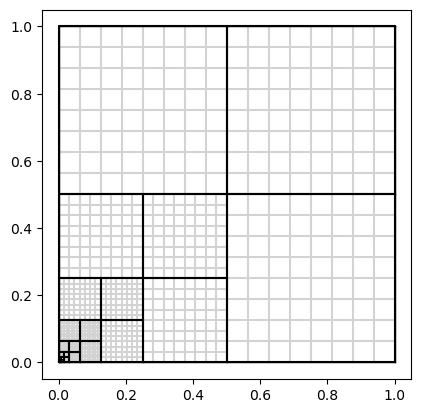

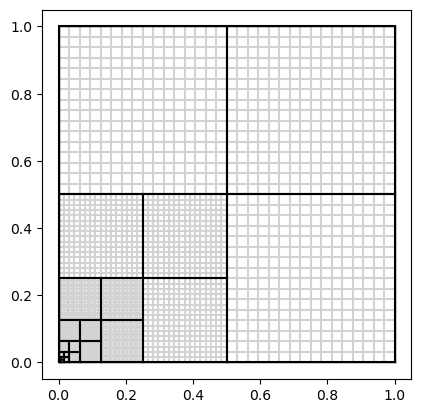

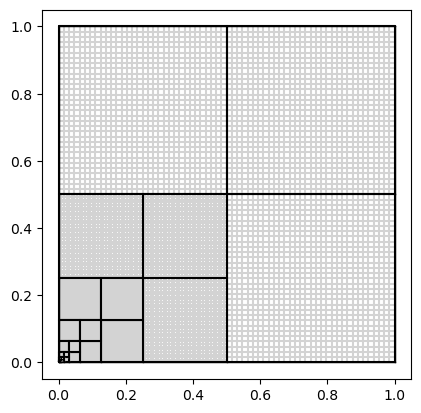

In [33]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
deg=2
elim=True

for N in (4,8,16,32):
    #patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.unit_square())]
    M = Lshape(deg,N)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    MP.mesh.draw(patch_idx=0,nodes=0,knots=1)
    t=time.time()
    I = IetiDP(MP, dir_data = {0:g}, elim=elim)
    print("Initializing took "+str(time.time()-t)+" seconds.")
    t=time.time()
    I.assemble(f=lambda x,y: 1.)
    print("Assembling took "+str(time.time()-t)+" seconds.")
    #print(I.rhsk)
    #print(I.Ak)
    t = time.time()
    I.construct_primal_constraints()
    I.construct_primal_basis()
    print("Constructing primal system took "+str(time.time()-t)+" seconds.")
    t = time.time()
    F,b= I.compute_F()
    print("Constructing Schur complement operator took "+str(time.time()-t)+" seconds.")
    t=time.time()
    MsD = I.MsD(pseudo=False)
    print("Constructing preconditioner took "+str(time.time()-t)+" seconds.")
    ### Solve the system with PCG
    lam, it, cond, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=200, P=MsD, output=1, tol=1e-8)
    #F_mat = F@np.eye(len(b))
    #cond = algebra.condest(MsD@F_mat)
    print(cond,((sqrt(cond)-1)/(sqrt(cond)+1))**it)
    print("#####################################################")

In [46]:
B = np.linalg.pinv(I.B_gamma.T@I.B_gamma.A)

In [57]:
spy(D)

NameError: name 'D' is not defined

In [71]:
Fmat = F.dot(np.eye(F.shape[0]))

In [73]:
algebra.condest(MsD@Fmat)

5.271205380497244

#####################################
setting up constraints took 0.018363237380981445 seconds.
Basis setup took 0.009409666061401367 seconds
4
10
pcg with preconditioned condition number 1.1104232399228329 stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00043201446533203125 seconds for 9 patches.
setting up constraints took 0.020048141479492188 seconds.
Basis setup took 0.009725570678710938 seconds
7
26
pcg with preconditioned condition number 1.242827242377967 stopped after 6 iterations with relres 9.877262513024327e-15
Refinement took 0.000331878662109375 seconds for 9 patches.
setting up constraints took 0.023079395294189453 seconds.
Basis setup took 0.01008152961730957 seconds
8
23
pcg with preconditioned condition number 1.3131180431114824 stopped after 6 iterations with relres 7.19027091678448e-11
Refinement took 0.0003571510314941406 seconds for 9 patches.
setting up constraints took 0.029850244522094727 seconds.
Basis setup took 0.01311326026916

/home/wolfman/anaconda3/lib/python3.9/site-packages/pyiga-0.1.0-py3.9-linux-x86_64.egg/pyiga/topology.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=kwargs.get('figsize'))


21
25
pcg with preconditioned condition number 1.769266987585349 stopped after 11 iterations with relres 2.2424118613517237e-11
Refinement took 0.0003402233123779297 seconds for 9 patches.
setting up constraints took 0.03714632987976074 seconds.
Basis setup took 0.018062114715576172 seconds
24
24
pcg with preconditioned condition number 1.7675684065257513 stopped after 11 iterations with relres 8.781202012645705e-11
Refinement took 0.00039577484130859375 seconds for 9 patches.
setting up constraints took 0.06232929229736328 seconds.
Basis setup took 0.034009695053100586 seconds
25
24
pcg with preconditioned condition number 1.7590407403296329 stopped after 12 iterations with relres 2.639155553047284e-11
Refinement took 0.00043511390686035156 seconds for 9 patches.
setting up constraints took 0.11404061317443848 seconds.
Basis setup took 0.09270548820495605 seconds


KeyboardInterrupt: 

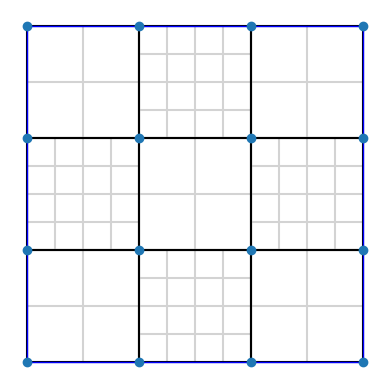

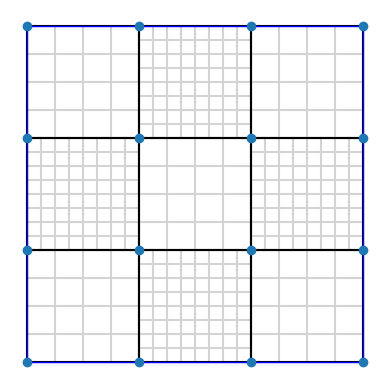

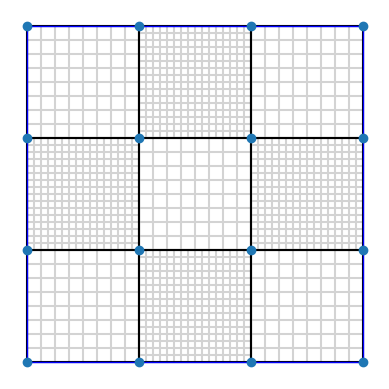

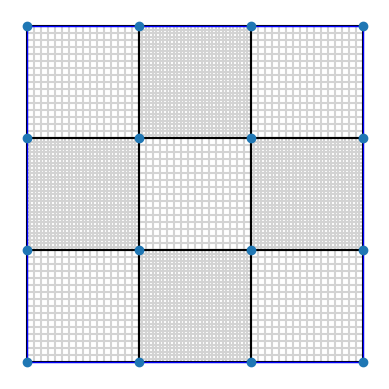

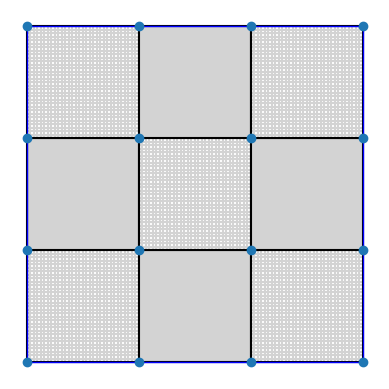

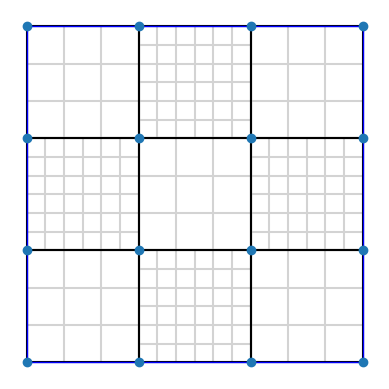

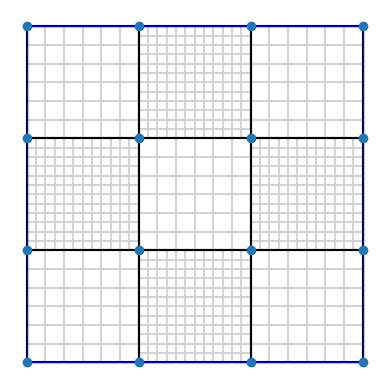

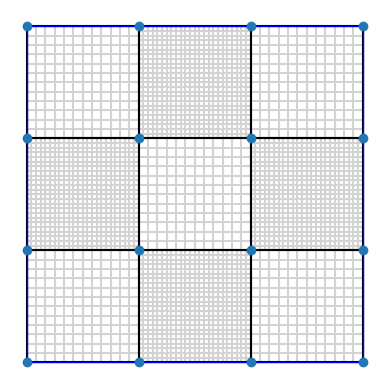

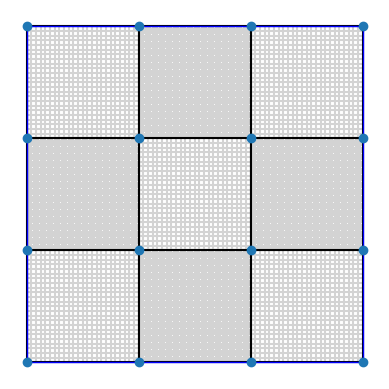

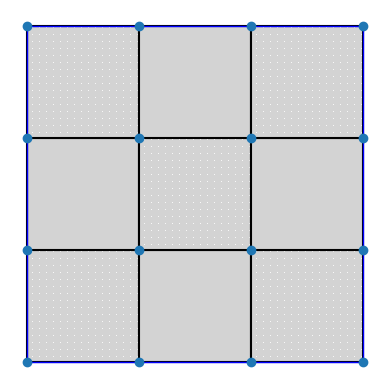

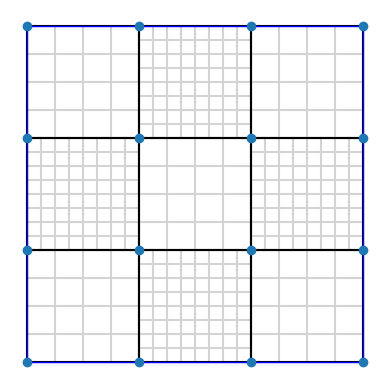

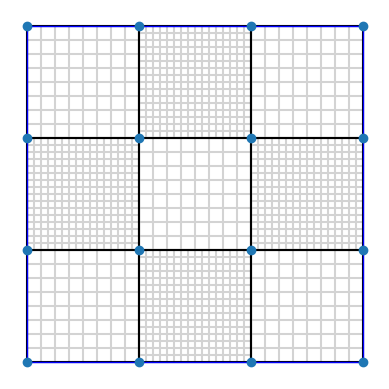

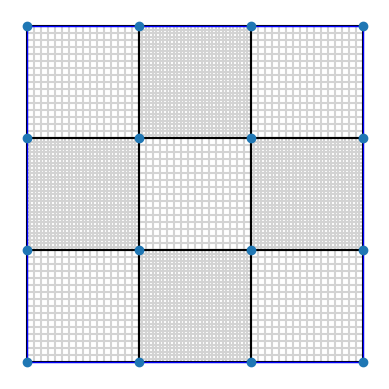

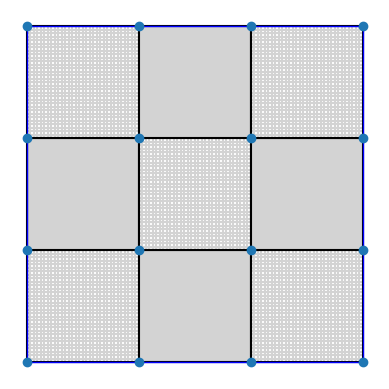

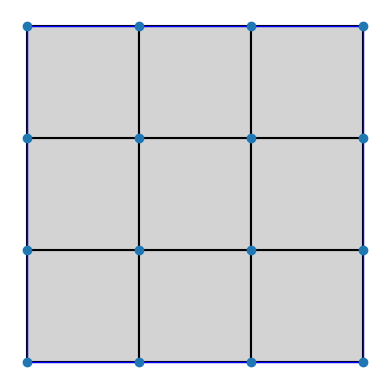

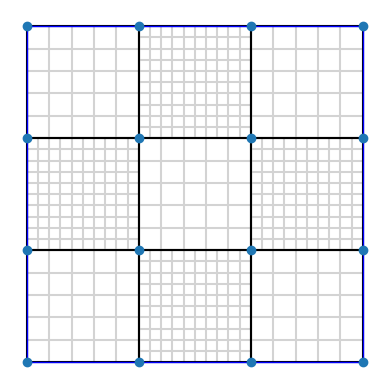

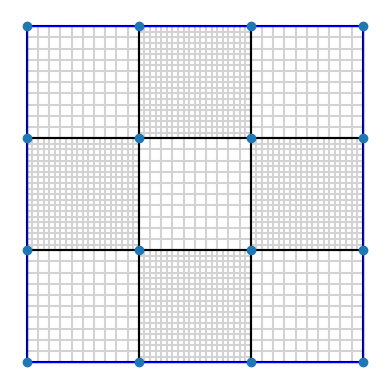

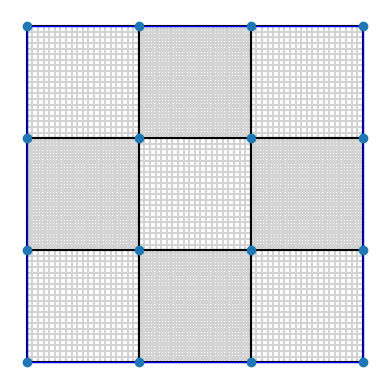

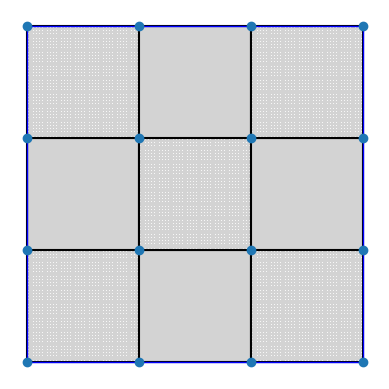

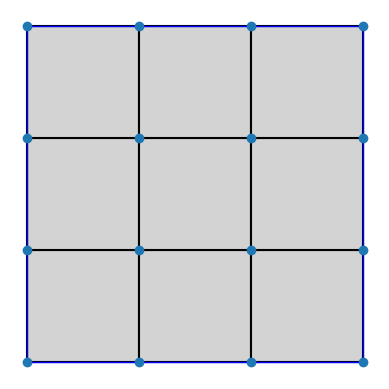

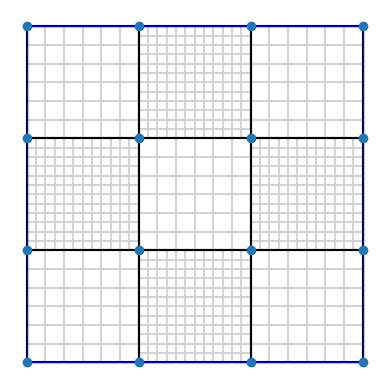

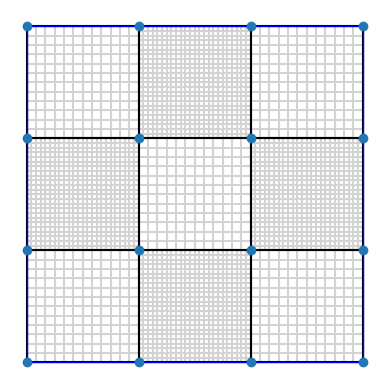

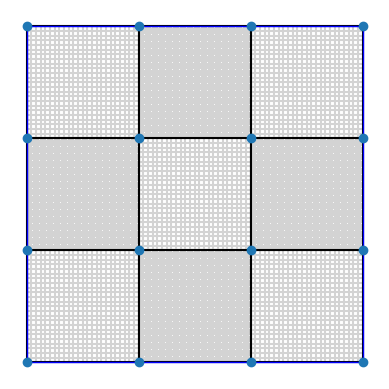

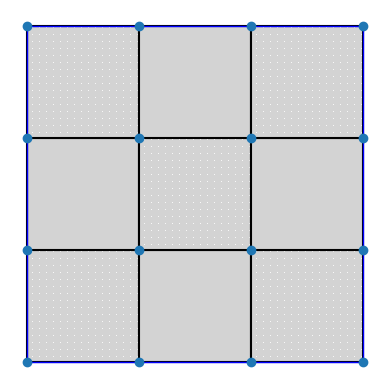

In [16]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = ieti.IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=True)
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.017437458038330078 seconds.
Basis setup took 0.009253501892089844 seconds
pcg stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00016951560974121094 seconds for 4 patches.
setting up constraints took 0.01792740821838379 seconds.
Basis setup took 0.00933218002319336 seconds
pcg stopped after 4 iterations with relres 4.273988115438311e-17
Refinement took 0.0001652240753173828 seconds for 4 patches.
setting up constraints took 0.019681930541992188 seconds.
Basis setup took 0.009746074676513672 seconds
pcg stopped after 4 iterations with relres 9.358588499822341e-15
Refinement took 0.00015854835510253906 seconds for 4 patches.
setting up constraints took 0.021558284759521484 seconds.
Basis setup took 0.011844396591186523 seconds
pcg stopped after 4 iterations with relres 4.58228236822898e-13
Refinement took 0.00017547607421875 seconds for 4 patches.
setting up constraints took 0.02753949165344

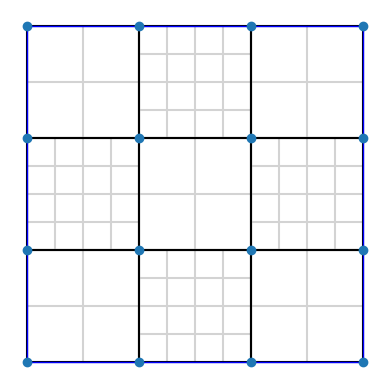

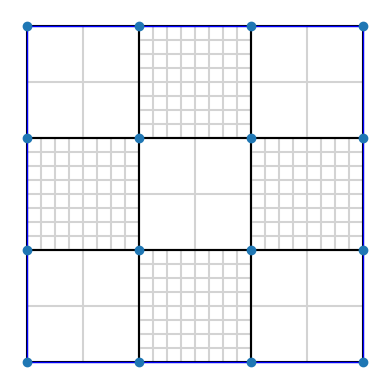

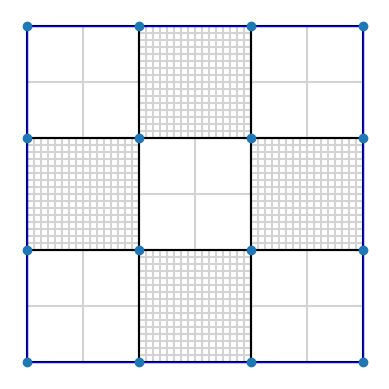

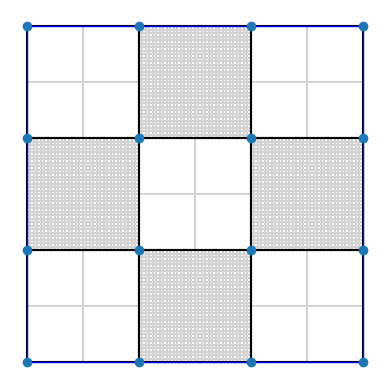

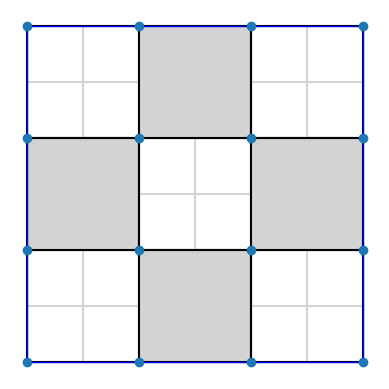

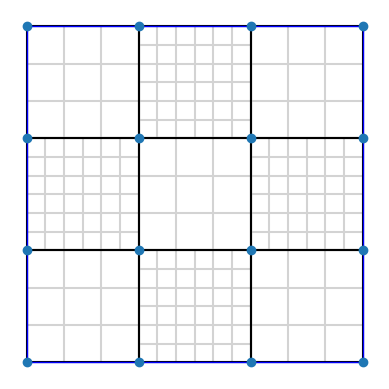

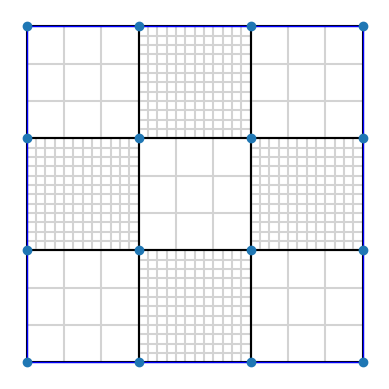

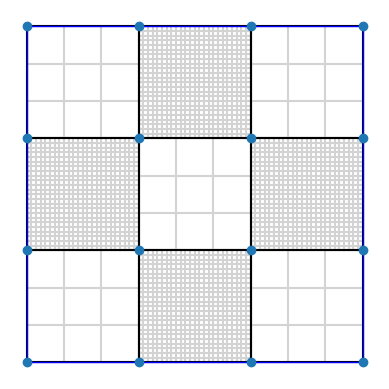

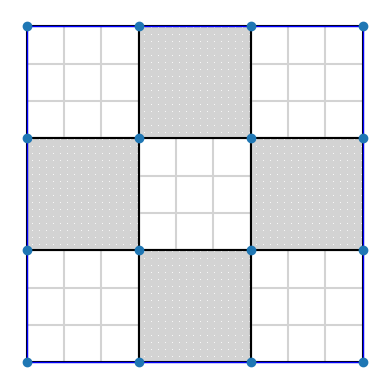

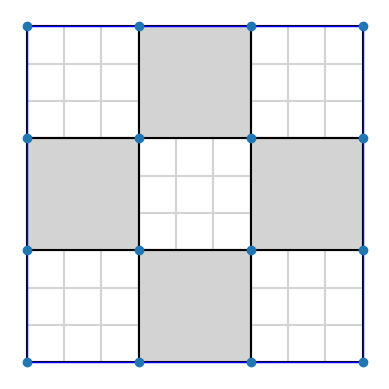

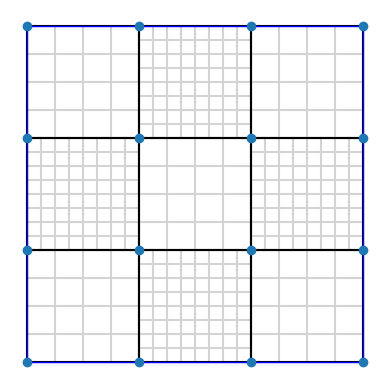

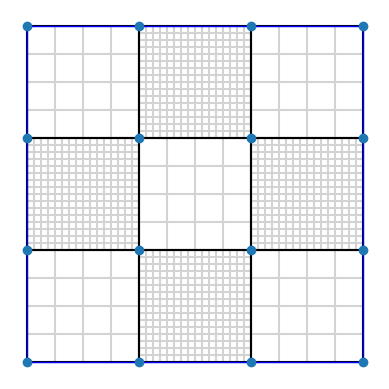

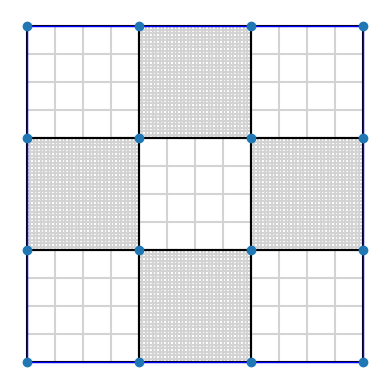

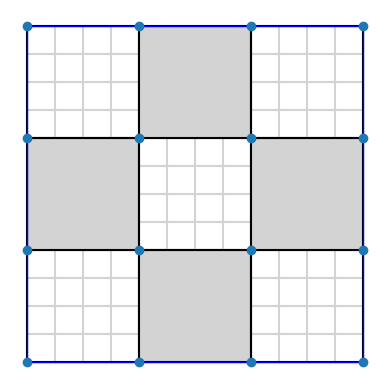

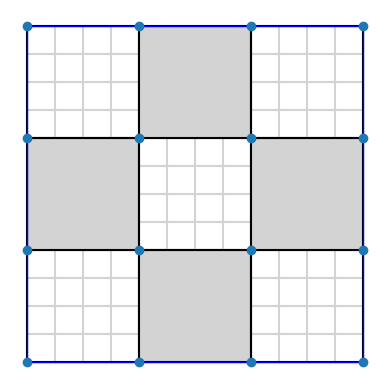

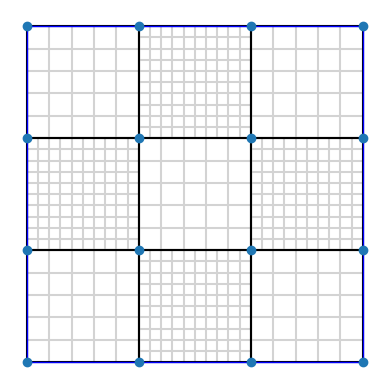

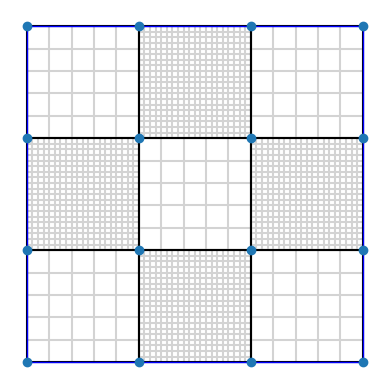

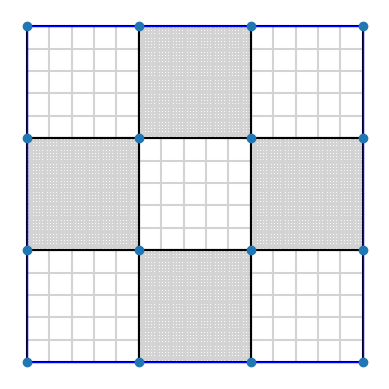

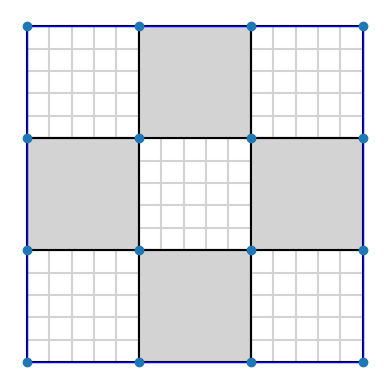

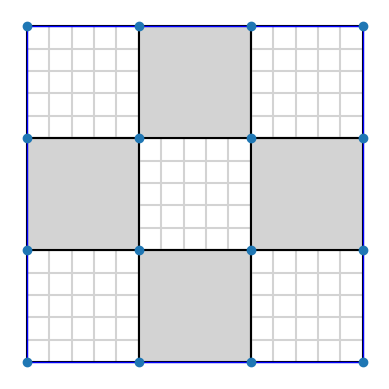

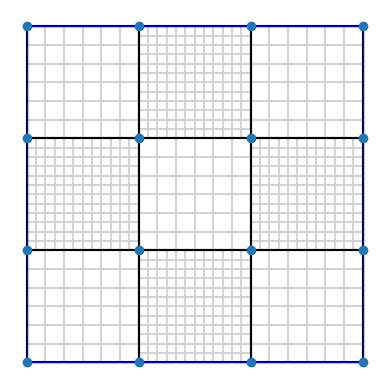

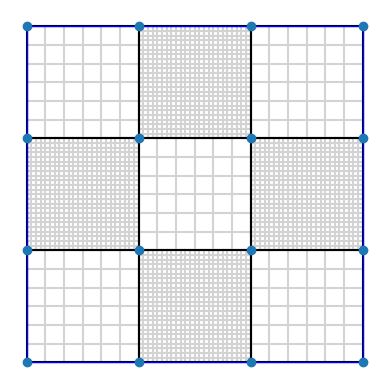

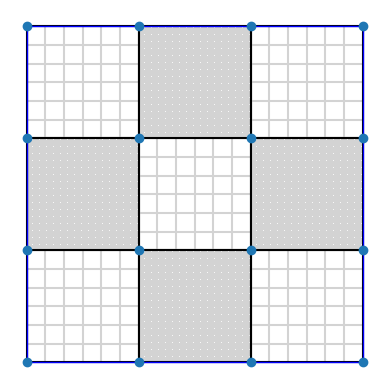

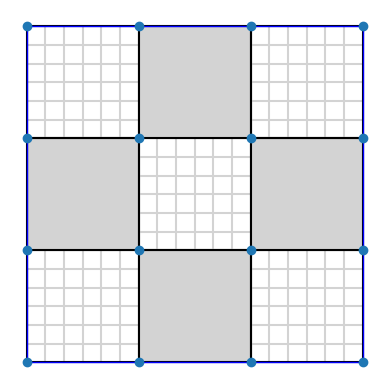

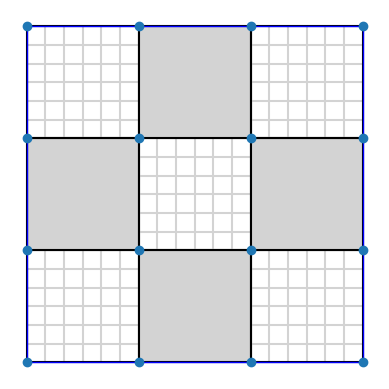

In [49]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD()
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        ###MP.h_refine(-1)
        MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

In [40]:
it

array([[1., 4., 4., 0., 0., 0.],
       [4., 6., 6., 0., 0., 0.],
       [5., 6., 7., 0., 0., 0.],
       [6., 7., 9., 0., 0., 0.],
       [7., 9., 9., 0., 0., 0.]])

In [ ]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((6,5))
it = np.zeros((6,5))
elim=True

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(6,))):
    print('#####################################')
    M = Lshape(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=False)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.08600449562072754 seconds.
Basis setup took 0.014266014099121094 seconds
pcg with preconditioned condition number 1.0972303562262358 stopped after 5 iterations with relres 2.1033830757006824e-11
Refinement took 0.0010564327239990234 seconds for 31 patches.
setting up constraints took 0.07834243774414062 seconds.
Basis setup took 0.013842582702636719 seconds
pcg with preconditioned condition number 1.671463683434546 stopped after 10 iterations with relres 4.9938397508517634e-11
Refinement took 0.0012252330780029297 seconds for 31 patches.
setting up constraints took 0.08354926109313965 seconds.
Basis setup took 0.015346527099609375 seconds
pcg with preconditioned condition number 1.2749844484684212 stopped after 13 iterations with relres 3.0492980297062935e-11
Refinement took 0.00106048583984375 seconds for 31 patches.
setting up constraints took 0.1029202938079834 seconds.
Basis setup took 0.020825624465942383 seconds


In [42]:
def sp_unique(sp_matrix, axis=0):
    ''' Returns a sparse matrix with the unique rows (axis=0)
    or columns (axis=1) of an input sparse matrix sp_matrix'''
    if axis == 1:
        sp_matrix = sp_matrix.T

    old_format = sp_matrix.getformat()
    dt = np.dtype(sp_matrix)
    ncols = sp_matrix.shape[1]

    if old_format != 'lil':
        sp_matrix = sp_matrix.tolil()

    _, ind = np.unique(sp_matrix.data + sp_matrix.rows, return_index=True)
    rows = sp_matrix.rows[ind]
    data = sp_matrix.data[ind]
    nrows_uniq = data.shape[0]

    sp_matrix = scipy.sparse.lil_matrix((nrows_uniq, ncols), dtype=dt)  #  or sp_matrix.resize(nrows_uniq, ncols)
    sp_matrix.data = data
    sp_matrix.rows = rows

    ret = sp_matrix.asformat(old_format)
    if axis == 1:
        ret = ret.T        
    return ret

In [50]:
def lexsort_row(A):
    ''' numpy lexsort of the rows, not used in sp_unique'''
    return A[np.lexsort(A.T[::-1])]

In [54]:
A = 10*scipy.sparse.random(100000, 3, 0.5, format='csr')
#A = np.ceil(A).astype(int)

    # unique rows
A_uniq = sp_unique(A, axis=0).toarray()
A_uniq = lexsort_row(A_uniq)
A_uniq_numpy = np.unique(A.toarray(), axis=0)
assert (A_uniq == A_uniq_numpy).all()

    # unique columns
A_uniq = sp_unique(A, axis=1).toarray()
A_uniq = lexsort_row(A_uniq.T).T
A_uniq_numpy = np.unique(A.toarray(), axis=1)
assert (A_uniq == A_uniq_numpy).all()  

In [18]:
### Set up the linear system
#A_ieti = scipy.sparse.bmat(
#    [[A,    C.T,  None, B.T  ],
#     [C,    None, None, None ],
#     [None, None, PTAP, PTBT ],
#     [B,    None, BP,   None ]], format='csr')

BL = scipy.sparse.bmat([[B,    np.zeros((B.shape[0],C.shape[0])), BP]], format='csr')
BR = scipy.sparse.bmat([[B.T],    
                        [np.zeros((C.shape[0],B.shape[0]))], 
                        [PTBT]], format='csr')
A0 = scipy.sparse.bmat(
    [[A,    C.T,  None],
     [C,    None, None],
     [None, None, PTAP]], format='csr')

print("Rank ", np.linalg.matrix_rank(PTAP.A), " vs. shape ", PTAP.shape)

b = np.hstack((rhs, np.zeros(C.shape[0],), PSI.dot(rhs), np.zeros(B.shape[0],)))

BR = scipy.sparse.linalg.aslinearoperator(BR)
BL = scipy.sparse.linalg.aslinearoperator(BL)
A0inv = solvers.make_solver(A0.A, spd=False)

F = BL@A0inv.dot(BR)

TR = np.hstack((rhs, np.zeros((C.shape[0],)), PSI.dot(rhs)))
b = BL@(A0inv.dot(TR))

"""
A0inv = scipy.sparse.linalg.spsolve(A0, BR.A)
F = BL@A0inv

A0inv = scipy.sparse.linalg.spsolve(A0, TR)
b = BL@A0inv
"""

Rank  4  vs. shape  (4, 4)


'\nA0inv = scipy.sparse.linalg.spsolve(A0, BR.A)\nF = BL@A0inv\n\nA0inv = scipy.sparse.linalg.spsolve(A0, TR)\nb = BL@A0inv\n'